In [1]:
import os
import time
from AC_GAN import *
import numpy as np
from torchvision.utils import save_image
import torch.optim as optim


In [2]:
EPOCHS = 200
BATCH_SIZE = 100
N_WORKERS = 4
HIDDEN_DIM = 100
NOISE_STD = 0.1
learning_rates = 0.0002
betas = (0.5, 0.999)
N_CLASS = 10
OUTPUT_IMG_GAP = 500

In [3]:
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  
])

import torchvision.datasets as dset
from torch.utils.data import DataLoader

DATA_ROOT = "./data"
train_set = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform_train
)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS
)

Files already downloaded and verified


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("GPU USED FOR TRAINING")
else:
    print("CPU USED FOR TRAINING")

# define the model
generator = Generator(NOISE_STD)
generator.apply(weights_init)
discriminator = Discriminator()
# discriminator.apply(weights_init)

# define the optimizers
optimizer_gen = optim.Adam(generator.parameters(), lr=learning_rates, betas=betas)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=learning_rates, betas=betas)

# define the loss function
dis_loss = nn.BCELoss().to(device)
cla_loss = nn.NLLLoss().to(device)

generator = generator.to(device)
discriminator = discriminator.to(device)
print(generator)
print(discriminator)

GPU USED FOR TRAINING
Generator(
  (fc1): Linear(in_features=110, out_features=384, bias=True)
  (tc1): Sequential(
    (conv): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (batchNorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (tc2): Sequential(
    (conv): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (tc3): Sequential(
    (conv): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (tc4): Sequential(
    (conv): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (tanh): Tanh()
  )
)
Discriminator(
  

In [5]:
start = time.time()
print("==> Training starts!")
print("="*100)
lossG_history = []
lossD_history = []

fixed_noise = None
Dx = 0
DGz1 = 0
DGz2 = 0

for i in range(EPOCHS):
    epoch_start = time.time()
    print("Epoch %d:" %i)

    lossG_record = []
    lossD_record = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        targets = targets.type(torch.LongTensor).to(device)
        batch_size = inputs.shape[0]
        real_ones = torch.ones((batch_size, 1), device=device)
        fake_ones = torch.zeros((batch_size, 1), device=device)
        # Train Generator
        nos = torch.randn(batch_size, HIDDEN_DIM)
        class_to_gen = torch.randint(0, N_CLASS, (batch_size,))
        one_hot_labels = torch.eye(N_CLASS)[class_to_gen]
        nw = torch.cat((nos, one_hot_labels), dim=1).to(device)
        class_labs = class_to_gen.type(torch.LongTensor).to(device)
        if fixed_noise is None:
            fixed_noise = nw.clone().detach().to(device)

        # give the generator
        img = generator(nw)
        real_or_fake1, fake_labs = discriminator(img)
        lossG1 = dis_loss(real_or_fake1, real_ones)
        lossG2 = cla_loss(fake_labs, class_labs)
        avg_lossG = lossG1 + lossG2
        DGz1 = real_or_fake1.data.mean()

        # zero the gradients and update the generator weights
        generator.zero_grad()
        avg_lossG.backward()
        optimizer_gen.step()

        #record the losses
        lossG_record.append(avg_lossG.cpu().detach().numpy())

        # Train Discriminator
        real_or_fake2, real_labs = discriminator(inputs)
        lossD1 = dis_loss(real_or_fake2, real_ones)
        lossD2 = cla_loss(real_labs, targets)
        Dx = real_or_fake2.data.mean()

        real_or_fake3, fake_labs2 = discriminator(img.detach())
        lossD3 = dis_loss(real_or_fake3, fake_ones)
        lossD4 = cla_loss(fake_labs2, class_labs)
        DGz2 = real_or_fake3.data.mean()

        # zero the gradients and update the weights
        avg_lossD = lossD1 + lossD2 + lossD3 + lossD4
        discriminator.zero_grad()
        avg_lossD.backward()
        optimizer_dis.step()

        #record the losses
        lossD_record.append(avg_lossD.cpu().detach().numpy())

        # output images
        if batch_idx % OUTPUT_IMG_GAP == 0:
            batches_done = i * len(train_loader) + batch_idx
            generated_images = generator(fixed_noise).data[:50]
            save_image(generated_images, os.path.join('./images', "%d.png" % batches_done), nrow=5, normalize=True)

    avg_loss_g = np.sum(np.asarray(lossG_record)) / len(lossG_record)
    avg_loss_d = np.sum(np.asarray(lossD_record)) / len(lossD_record)
    print("D_x: %.4f, D_G_z1: %.4f, D_G_z2: %.4f"%(Dx, DGz1, DGz2))
    print("Generator loss: %.4f, Discriminator loss: %.4f"%(avg_loss_g, avg_loss_d))

    lossG_history.append(avg_loss_g)
    lossD_history.append(avg_loss_d)

    # save the model checkpoint
    torch.save(generator.state_dict(), os.path.join('./model', 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join('./model', 'discriminator.pth'))
    print(f"Epoch finished in {time.time() - epoch_start:.2f}s")
    print("")

print("="*100)
print(f"==> Optimization finished in {time.time() - start:.2f}s!")

==> Training starts!
Epoch 0:
D_x: 0.5177, D_G_z1: 0.4529, D_G_z2: 0.4724
Generator loss: 1.0316, Discriminator loss: 0.8541
Epoch finished in 37.48s

Epoch 1:
D_x: 0.5814, D_G_z1: 0.4655, D_G_z2: 0.4464
Generator loss: 0.6545, Discriminator loss: 0.8468
Epoch finished in 36.78s

Epoch 2:
D_x: 0.5903, D_G_z1: 0.4541, D_G_z2: 0.4436
Generator loss: 0.2593, Discriminator loss: 0.4535
Epoch finished in 40.50s

Epoch 3:
D_x: 0.5562, D_G_z1: 0.4330, D_G_z2: 0.4457
Generator loss: 0.0776, Discriminator loss: 0.2630
Epoch finished in 36.15s

Epoch 4:
D_x: 0.6392, D_G_z1: 0.4320, D_G_z2: 0.4437
Generator loss: 0.1484, Discriminator loss: 0.2246
Epoch finished in 35.40s

Epoch 5:
D_x: 0.4247, D_G_z1: 0.4092, D_G_z2: 0.4018
Generator loss: 0.1358, Discriminator loss: 0.1503
Epoch finished in 34.90s

Epoch 6:
D_x: 0.7066, D_G_z1: 0.2918, D_G_z2: 0.3349
Generator loss: 0.1590, Discriminator loss: 0.0677
Epoch finished in 34.33s

Epoch 7:
D_x: 0.4962, D_G_z1: 0.2973, D_G_z2: 0.2693
Generator loss: 

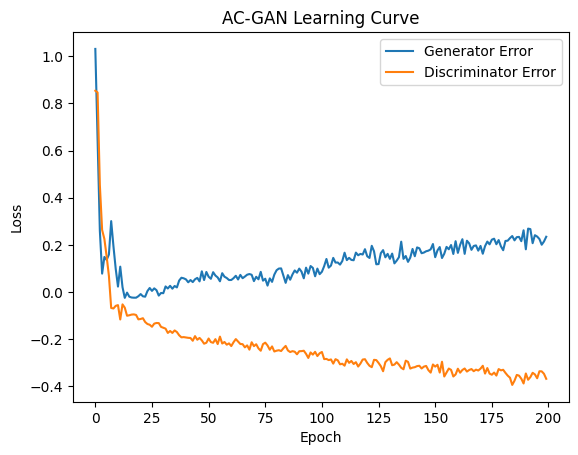

In [6]:
import matplotlib.pyplot as plt
plt.plot(lossG_history, label='Generator Error')
plt.plot(lossD_history, label='Discriminator Error')
plt.title("AC-GAN Learning Curve")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()